Epoch 1/10: Loss G: 1.541308879852295, Loss D: 0.4451526403427124
Epoch 2/10: Loss G: 1.6040949821472168, Loss D: 0.7277421355247498
Epoch 3/10: Loss G: 1.8103779554367065, Loss D: 0.430711030960083
Epoch 4/10: Loss G: 1.8265812397003174, Loss D: 0.46975478529930115
Epoch 5/10: Loss G: 1.2305803298950195, Loss D: 0.45086175203323364
Epoch 6/10: Loss G: 1.5081645250320435, Loss D: 0.49267739057540894
Epoch 7/10: Loss G: 1.4053266048431396, Loss D: 0.44300931692123413
Epoch 8/10: Loss G: 1.863800048828125, Loss D: 0.4972952604293823
Epoch 9/10: Loss G: 1.571885585784912, Loss D: 0.38303232192993164
Epoch 10/10: Loss G: 1.2468574047088623, Loss D: 0.46386945247650146


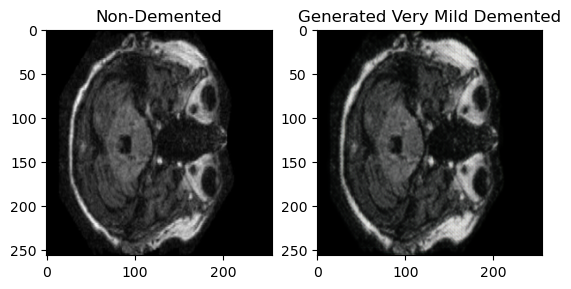

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import itertools

# 1. Dataset Preparation
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mild_demented = [os.path.join(root_dir, 'Mild Dementia', img) for img in os.listdir(os.path.join(root_dir, 'Mild Dementia'))]
        self.moderate_dementia = [os.path.join(root_dir, 'Moderate Dementia', img) for img in os.listdir(os.path.join(root_dir, 'Moderate Dementia'))]
        self.length = min(len(self.mild_demented), len(self.moderate_dementia))
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        img_A = Image.open(self.mild_demented[idx]).convert("RGB")
        img_B = Image.open(self.moderate_dementia[idx]).convert("RGB")
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        return img_A, img_B

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

root=r"C:\Users\sanja\Downloads\CS584-Project\data\source_2"

dataset = AlzheimerDataset(root_dir=root, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 2. CycleGAN Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# 3. Loss and Optimizers
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(itertools.chain(D_A.parameters(), D_B.parameters()), lr=0.0002, betas=(0.5, 0.999))

# 4. Training Loop
for epoch in range(10):
    for i, (real_A, real_B) in enumerate(dataloader):
        real_A, real_B = real_A.to(device), real_B.to(device)
        
        # Train Generators
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))
        loss_cycle_A = criterion_cycle(G_BA(fake_B), real_A)
        loss_cycle_B = criterion_cycle(G_AB(fake_A), real_B)
        loss_G = loss_GAN_AB + loss_GAN_BA + 10 * (loss_cycle_A + loss_cycle_B)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators
        loss_D_A = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A))) + criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
        loss_D_B = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B))) + criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
        loss_D = (loss_D_A + loss_D_B) / 2
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

    print(f"Epoch {epoch+1}/10: Loss G: {loss_G.item()}, Loss D: {loss_D.item()}")


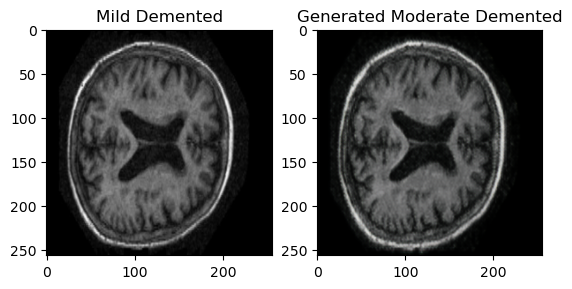

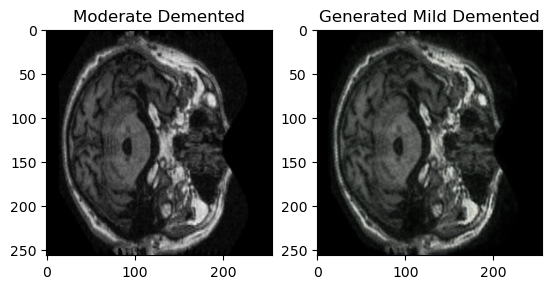

In [17]:
# 5. Evaluate & Compare Images
def compare_images():
    real_A, _ = next(iter(dataloader))
    real_A = real_A.to(device)
    fake_B = G_AB(real_A).cpu().detach()
    real_A = real_A.cpu()
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(real_A[0].permute(1, 2, 0) * 0.5 + 0.5)
    ax[0].set_title("Mild Demented")
    ax[1].imshow(fake_B[0].permute(1, 2, 0) * 0.5 + 0.5)
    ax[1].set_title("Generated Moderate Demented")
    plt.show()

    _, real_B = next(iter(dataloader))
    real_B = real_B.to(device)
    fake_A = G_BA(real_B).cpu().detach()
    real_B = real_B.cpu()
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(real_B[0].permute(1, 2, 0) * 0.5 + 0.5)
    ax[0].set_title("Moderate Demented")
    ax[1].imshow(fake_A[0].permute(1, 2, 0) * 0.5 + 0.5)
    ax[1].set_title("Generated Mild Demented")
    plt.show()

compare_images()

In [20]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F
import numpy as np

def evaluate_model():
    total_ssim = 0
    total_mse = 0
    num_samples = 0

    with torch.no_grad():
        for _, real_B in dataloader:  # Only using real_B for comparison
            real_B = real_B.to(device)
            fake_A = G_BA(real_B).cpu().detach()
            real_B = real_B.cpu()

            # Convert tensors to numpy arrays for SSIM calculation
            real_B_img = real_B[0].permute(1, 2, 0).numpy()
            fake_A_img = fake_A[0].permute(1, 2, 0).numpy()

            # Normalize the images to range (0,1) since SSIM expects valid intensity values
            real_B_img = (real_B_img - real_B_img.min()) / (real_B_img.max() - real_B_img.min() + 1e-5)
            fake_A_img = (fake_A_img - fake_A_img.min()) / (fake_A_img.max() - fake_A_img.min() + 1e-5)

            # Compute SSIM with a smaller window size
            ssim_score = ssim(real_B_img, fake_A_img, channel_axis=-1, data_range=1.0, win_size=11)
            total_ssim += ssim_score

            # Compute MSE
            mse_score = F.mse_loss(fake_A, real_B).item()
            total_mse += mse_score

            num_samples += 1

    avg_ssim = total_ssim / num_samples
    avg_mse = total_mse / num_samples

    print(f"Model Evaluation - SSIM: {avg_ssim:.4f}, MSE: {avg_mse:.4f}")

# Run the evaluation
evaluate_model()


Model Evaluation - SSIM: 0.9244, MSE: 0.0064
